In [1]:
import sys 
from pathlib import Path
project_root = (Path.cwd() / "../../").resolve()
sys.path.append(str(project_root))

In [2]:
import pandas as pd
import seaborn as sns
from pathlib import Path
import matplotlib.pyplot as plt
from itertools import product
import numpy as np


In [3]:
data_path = project_root / "data"

# Loading The Data

## Data fields

Most of the fields are self-explanatory. The following are descriptions for those that aren't.

* **Id**  an Id that represents a (Store, Date) duple within the test set
* **Store**  a unique Id for each store
* **Sales**  the turnover for any given day (this is what you are predicting)
* **Customers**  the number of customers on a given day
* **Open**  an indicator for whether the store was open: 0 = closed, 1 = open
* **StateHoliday**  indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None
* **SchoolHoliday**  indicates if the (Store, Date) was affected by the closure of public schools
* **StoreType**  differentiates between 4 different store models: a, b, c, d
* **Assortment**  describes an assortment level: a = basic, b = extra, c = extended
* **CompetitionDistance**  distance in meters to the nearest competitor store
* **CompetitionOpenSince[Month/Year]**  gives the approximate year and month of the time the nearest competitor was opened
* **Promo**  indicates whether a store is running a promo on that day
* **Promo2**  Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating
* **Promo2Since[Year/Week]**  describes the year and calendar week when the store started participating in Promo2
* **PromoInterval**  describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store


In [4]:

# load train data
from rossmann.model.data_loader import load_instances_csv, load_stores_csv
from rossmann.model.prepare_data import prepare_stores
from rossmann.model.pipeline.filter import TopStoreSelector
from rossmann.model.pipeline import make_feature_extractor
from sklearn.compose import make_column_selector

def range(col):
    return max(col) - min(col)

summarizers = ["min", "max", "count", "nunique", range]

## Training Data
### Load and conver to Right Types

In [5]:
train = load_instances_csv(data_path / "train.csv")
test = load_instances_csv(data_path / "test.csv")
subset_train = TopStoreSelector(top_percent=0.1).fit_transform(train)
# To compare distributions
sampled_rest = train[~train.index.isin(subset_train.index)].sample(len(subset_train))
subset_train.info()
subset_train.head()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 49742 entries, (84, Timestamp('2015-07-31 00:00:00')) to (1114, Timestamp('2013-01-01 00:00:00'))
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   DayOfWeek      49742 non-null  int64   
 1   Sales          49742 non-null  int64   
 2   Customers      49742 non-null  int64   
 3   Open           49742 non-null  bool    
 4   Promo          49742 non-null  bool    
 5   StateHoliday   49742 non-null  category
 6   SchoolHoliday  49742 non-null  bool    
dtypes: bool(3), category(1), int64(3)
memory usage: 1.5 MB


DayOfWeek  Sales  Customers  Open  Promo StateHoliday  \
Store Date                                                                
84    2015-07-31          5  14949       1439  True   True   no holiday   
      2015-07-30          4  12928       1255  True   True   no holiday   
      2015-07-29          3  15367       1511  True   True   no holiday   
      2015-07-28          2  14892       1383  True   True   no holiday   
      2015-07-27          1  16104       1412  True   True   no holiday   

                  SchoolHoliday  
Store Date                       
84    2015-07-31           True  
      2015-07-30           True  
      2015-07-29           True  
      2015-07-28           True  
      2015-07-27           True

In [6]:
stores = load_stores_csv(data_path / "store.csv")
stores.info()
stores.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1115 entries, 1 to 1115
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   StoreType             1115 non-null   category      
 1   Assortment            1115 non-null   category      
 2   CompetitionDistance   1112 non-null   float64       
 3   Promo2                1115 non-null   bool          
 4   PromoInterval         1115 non-null   object        
 5   CompetitionOpenSince  761 non-null    datetime64[ns]
 6   Promo2Since           571 non-null    datetime64[ns]
dtypes: bool(1), category(2), datetime64[ns](2), float64(1), object(1)
memory usage: 47.1+ KB


,StoreType,Assortment,CompetitionDistance,Promo2,PromoInterval,CompetitionOpenSince,Promo2Since
Store,,,,,,,
1,c,basic,1270.0,False,[],2008-09-01,NaT
2,a,basic,570.0,True,"[1, 4, 7, 10]",2007-11-01,2010-03-29
3,a,basic,14130.0,True,"[1, 4, 7, 10]",2006-12-01,2011-04-04
4,c,extended,620.0,False,[],2009-09-01,NaT
5,a,basic,29910.0,False,[],2015-04-01,NaT


In [7]:

prepared_stores = prepare_stores(train, stores)
prepared_stores.info()
prepared_stores.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1115 entries, 1 to 1115
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   StoreType             1115 non-null   category      
 1   Assortment            1115 non-null   category      
 2   CompetitionDistance   1115 non-null   float64       
 3   Promo2                1115 non-null   bool          
 4   PromoInterval         1115 non-null   object        
 5   CompetitionOpenSince  1115 non-null   datetime64[ns]
 6   Promo2Since           571 non-null    datetime64[ns]
 7   HolidayGroup          1115 non-null   category      
dtypes: bool(1), category(3), datetime64[ns](2), float64(1), object(1)
memory usage: 48.6+ KB


,StoreType,Assortment,CompetitionDistance,Promo2,PromoInterval,CompetitionOpenSince,Promo2Since,HolidayGroup
Store,,,,,,,,
1,c,basic,1270.0,False,[],2008-09-01,NaT,10
2,a,basic,570.0,True,"[1, 4, 7, 10]",2007-11-01,2010-03-29,5
3,a,basic,14130.0,True,"[1, 4, 7, 10]",2006-12-01,2011-04-04,1
4,c,extended,620.0,False,[],2009-09-01,NaT,6
5,a,basic,29910.0,False,[],2015-04-01,NaT,0


In [8]:
feature_extractor = make_feature_extractor(prepared_stores)
feature_extractor


Pipeline(steps=[('date_features',
                 <rossmann.model.pipeline.feature_extraction.DateEncoder object at 0x7f96c1b46460>),
                ('promo2_features',
                 <rossmann.model.pipeline.feature_extraction.Promo2Extractor object at 0x7f96c1b46100>),
                ('competition_open_features',
                 <rossmann.model.pipeline.feature_extraction.DaySinceCompetitionOpenedExtractor object at 0x7f96c1b46220>),
                ('store_features',
                 <rossmann.model.pipeline.feature_extraction.DataFrameFeatureExtractor object at 0x7f9722445fd0>)])

In [11]:
 set(subset_train_extracted_features.columns)  - set(subset_train.columns)

{'Assortment',
 'CompetitionDistance',
 'CompetitionOpen',
 'CompetitionOpenSinceDays',
 'Day',
 'DayOfYear',
 'DaysSinceStart',
 'HolidayGroup',
 'Month',
 'Promo2',
 'StoreType',
 'Year'}

## Feature Extraction Pipeline

Adds the feaatures: 
* Assortment / StoreType / CompetitionDistance: looked up from stored
* CompetitionOpen / CompetitionOpenSinceDays: 
* Day / DayOfYear / Month / Year : integers to indicate the, calcualted from Date
* HolidayGroup: grouped the stored by patter of holidays -> indicator for bundesland
* Promo2: promo2 at this day
* DaysSinceStart: number of days since the store take part of Promo2

In [9]:
subset_train_extracted_features = feature_extractor.fit_transform(subset_train)
sampled_rest_extracted_features = feature_extractor.transform(sampled_rest)
test_extracted_features = feature_extractor.transform(test)
subset_train_extracted_features.info()
subset_train_extracted_features.head()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 49742 entries, (84, Timestamp('2015-07-31 00:00:00')) to (1114, Timestamp('2013-01-01 00:00:00'))
Data columns (total 19 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   DayOfWeek                 49742 non-null  int64   
 1   Sales                     49742 non-null  int64   
 2   Customers                 49742 non-null  int64   
 3   Open                      49742 non-null  bool    
 4   Promo                     49742 non-null  bool    
 5   StateHoliday              49742 non-null  category
 6   SchoolHoliday             49742 non-null  bool    
 7   Day                       49742 non-null  int64   
 8   Year                      49742 non-null  int64   
 9   Month                     49742 non-null  int64   
 10  DayOfYear                 49742 non-null  int64   
 11  DaysSinceStart            49742 non-null  int64   
 12  Promo2                    4974

DayOfWeek  Sales  Customers  Open  Promo StateHoliday  \
Store Date                                                                
84    2015-07-31          5  14949       1439  True   True   no holiday   
      2015-07-30          4  12928       1255  True   True   no holiday   
      2015-07-29          3  15367       1511  True   True   no holiday   
      2015-07-28          2  14892       1383  True   True   no holiday   
      2015-07-27          1  16104       1412  True   True   no holiday   

                  SchoolHoliday  Day  Year  Month  DayOfYear  DaysSinceStart  \
Store Date                                                                     
84    2015-07-31           True   31  2015      7        212             941   
      2015-07-30           True   30  2015      7        211             940   
      2015-07-29           True   29  2015      7        210             939   
      2015-07-28           True   28  2015      7        209             938   
      2015-07-27           True   27  2015      7        208             937   

                  Promo2  CompetitionOpenSinceDays  CompetitionOpen StoreType  \
Store Date                                                                      
84    2015-07-31   False                       364             True         a   
      2015-07-30   False                       363             True         a   
      2015-07-29   False                       362             True         a   
      2015-07-28   False                       361             True         a   
      2015-07-27   False                       360             True         a   

                 Assortment  CompetitionDistance HolidayGroup  
Store Date                                                     
84    2015-07-31   extended              11810.0            1  
      2015-07-30   extended              11810.0            1  
      2015-07-29   extended              11810.0            1  
      2015-07-28   extended              11810.0            1  
      2015-07-27   extended              11810.0            1

In [86]:
test_extracted_features.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 41088 entries, (1, Timestamp('2015-09-17 00:00:00')) to (1115, Timestamp('2015-08-01 00:00:00'))
Data columns (total 18 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   Id                        41088 non-null  int64   
 1   DayOfWeek                 41088 non-null  int64   
 2   Open                      41088 non-null  boolean 
 3   Promo                     41088 non-null  boolean 
 4   StateHoliday              41088 non-null  category
 5   SchoolHoliday             41088 non-null  boolean 
 6   Day                       41088 non-null  int64   
 7   Year                      41088 non-null  int64   
 8   Month                     41088 non-null  int64   
 9   DayOfYear                 41088 non-null  int64   
 10  DaysSinceStart            41088 non-null  int64   
 11  Promo2                    41088 non-null  bool    
 12  CompetitionOpenSinceDays  41088

## Compare subset_train vs samples_rest feature and target dists

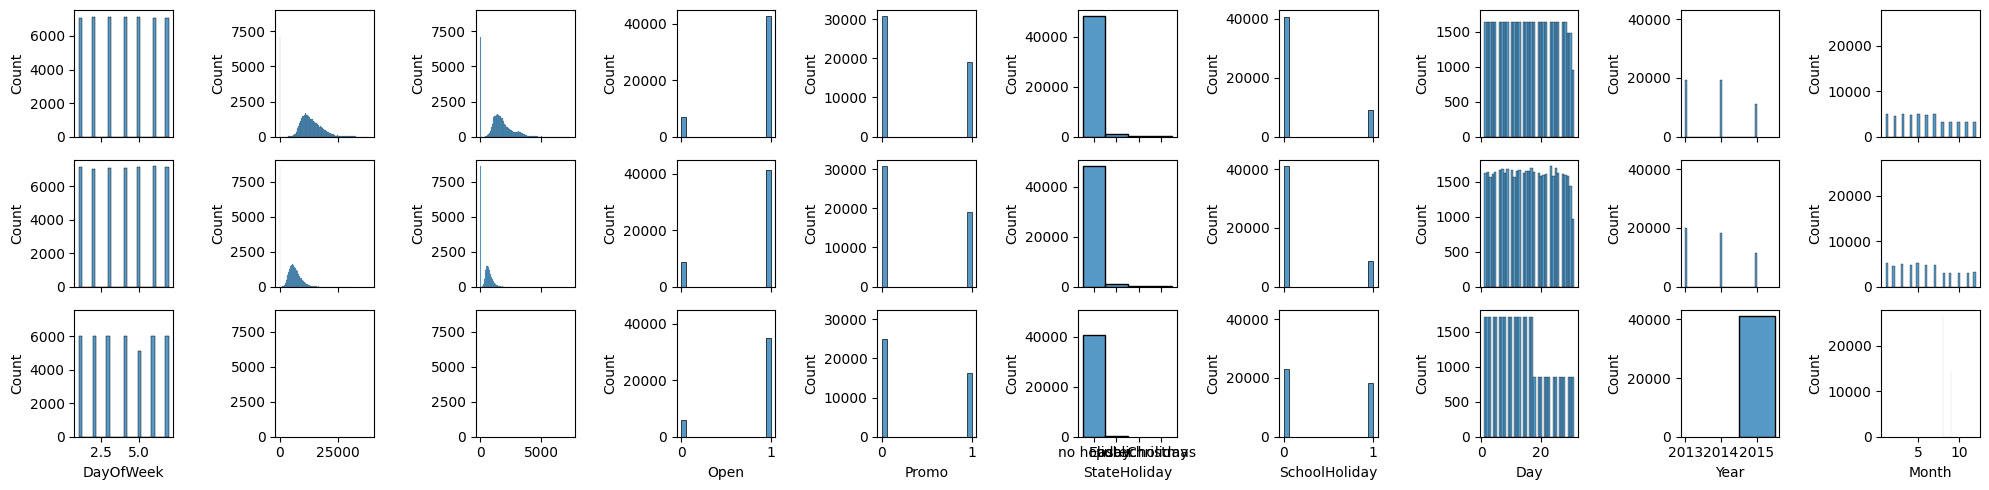

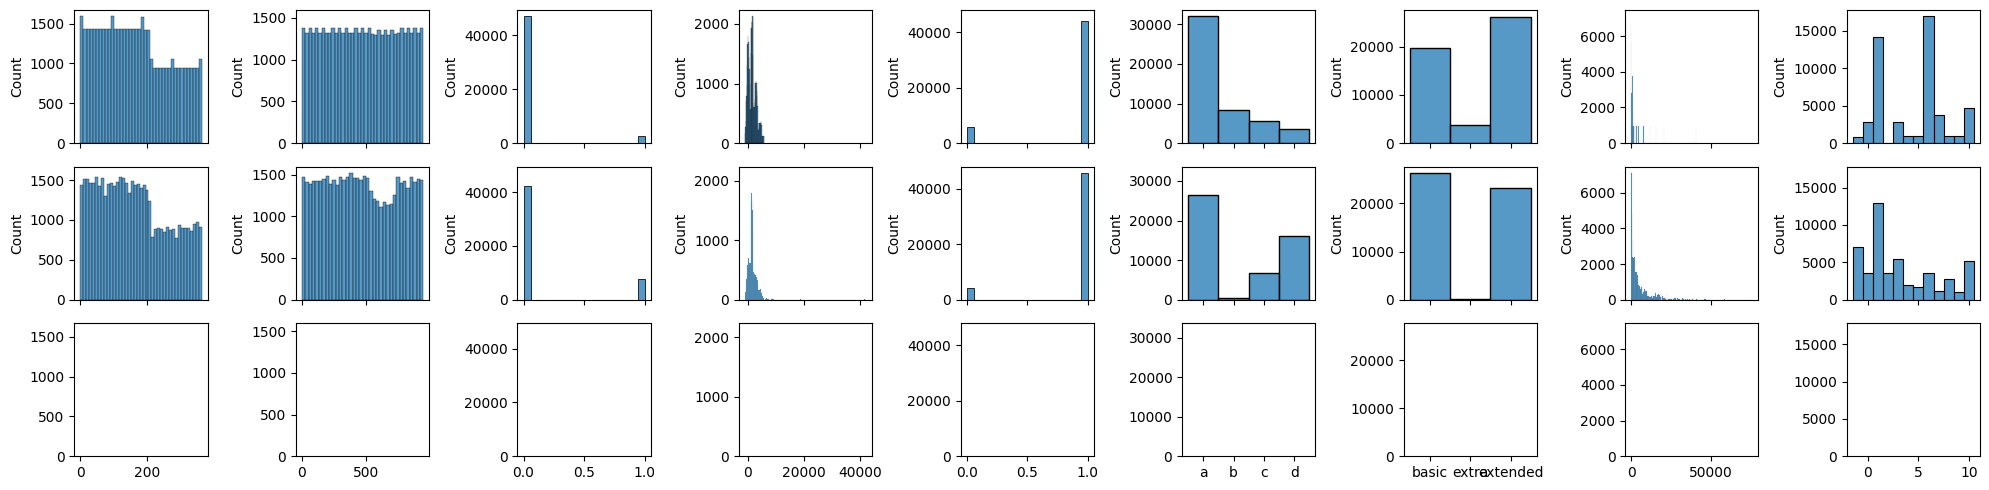

In [77]:
cols = subset_train_extracted_features.columns[:10]
dfs = [subset_train_extracted_features, sampled_rest_extracted_features, test_extracted_features]
fig, axes = plt.subplots(nrows=3, ncols=len(cols), figsize=(20, 5), sharex="col", sharey="col")

for (data, col), ax in zip(product(dfs, cols), axes.flat):
    if col not in data.columns:
        continue
    col_data = data[col]
    if col_data.dtype in ["boolean", "bool"]:
        col_data = col_data.astype(int)
        
    sns.histplot(col_data, ax=ax)
plt.tight_layout()
cols = subset_train_extracted_features.columns[10:]
dfs = [subset_train_extracted_features, sampled_rest_extracted_features]
fig, axes = plt.subplots(nrows=3, ncols=len(cols), figsize=(20, 5), sharex="col", sharey="col")

for (data, col), ax in zip(product(dfs, cols), axes.flat):
    if col not in data.columns:
        continue
    col_data = data[col]
    if col_data.dtype in ["boolean", "bool"]:
        col_data = col_data.astype(int)
    
    sns.histplot(col_data, ax=ax)
plt.tight_layout()

### Takeaway
* Assortment, StoreType, HolidayGroup, Sales: not equally distributes in both splits

# Sales Over Time

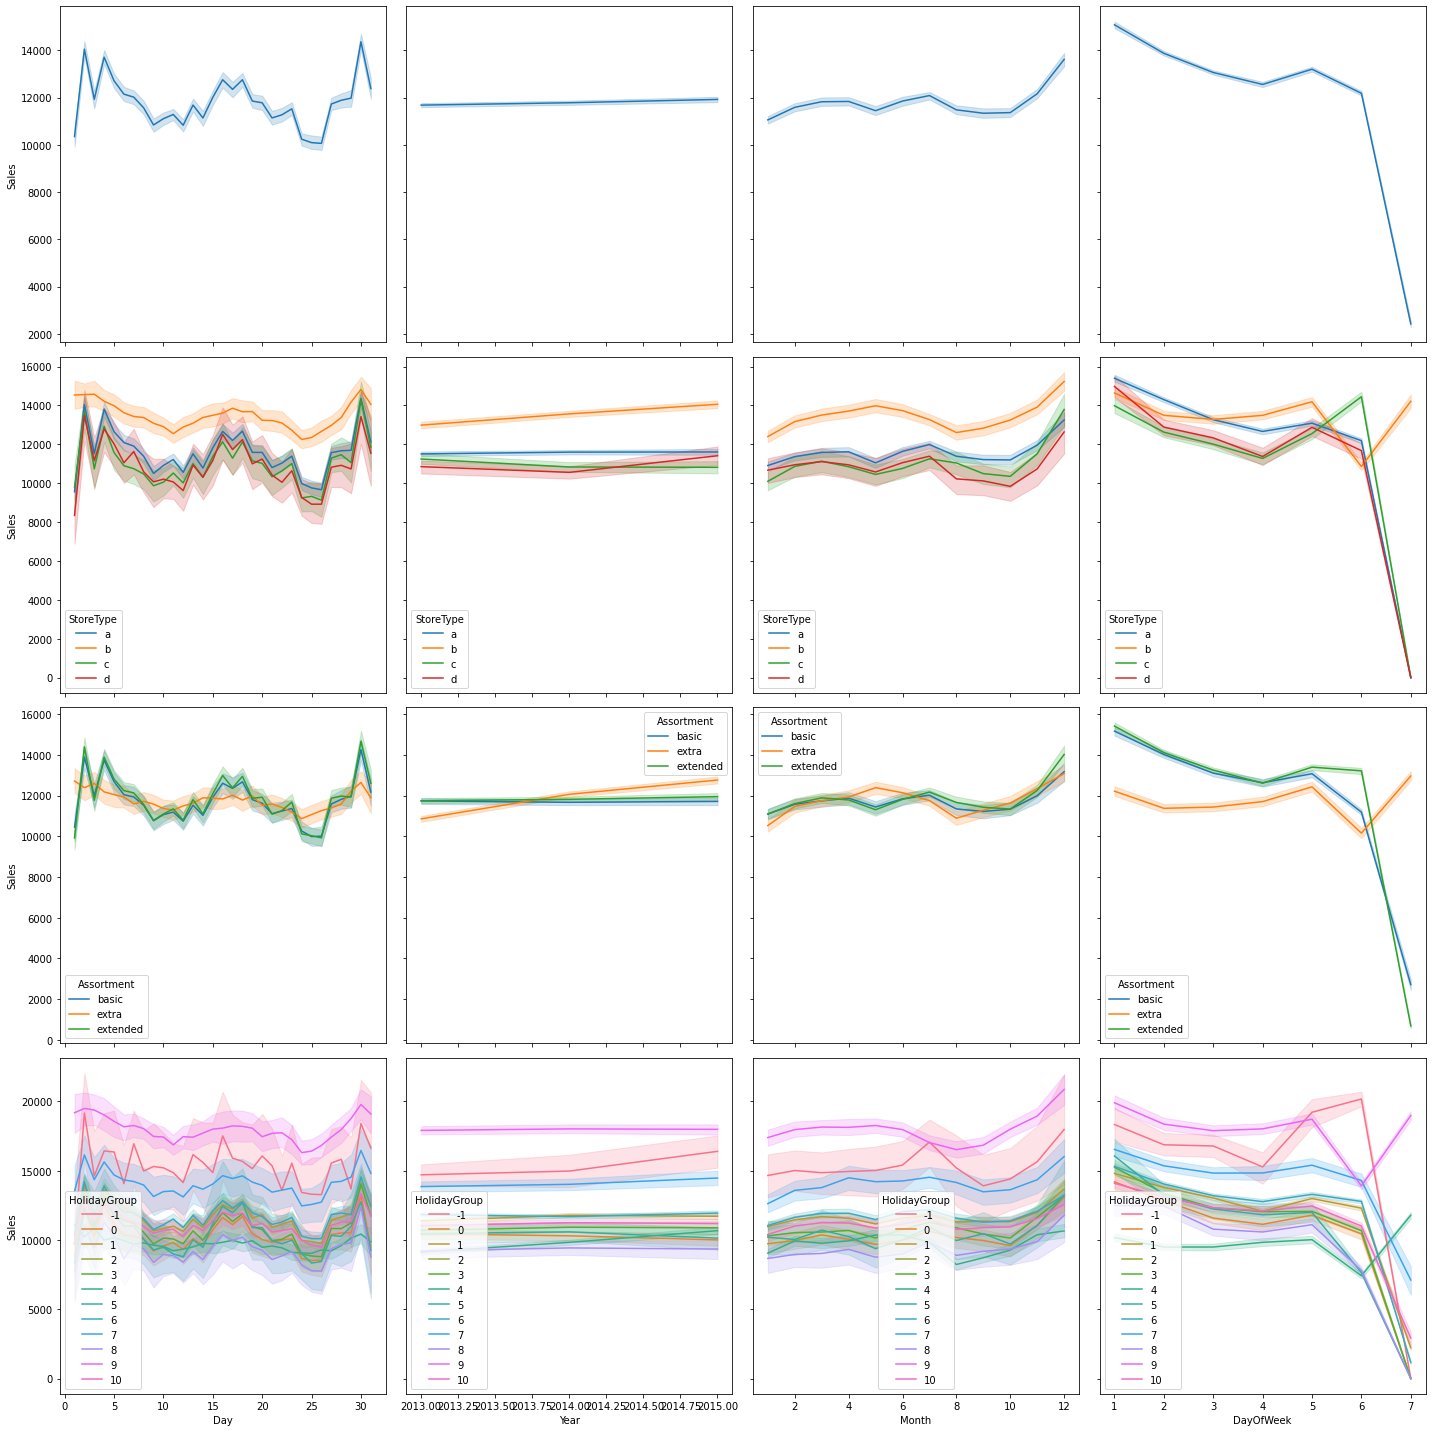

In [22]:
freqs = ["Day", "Year", "Month", "DayOfWeek"]
cats = [None, "StoreType", "Assortment", "HolidayGroup"]

fig, axes = plt.subplots(
    nrows=len(cats), 
    ncols=len(freqs), figsize=(20, 20), sharex="col", sharey="row")
for (cat, freq), ax in zip(product(cats, freqs), axes.flat):
    sns.lineplot(x=freq, y="Sales", data=subset_train_extracted_features, hue=cat, ax=ax)
    

plt.tight_layout()

### Takeaways 
* Day probalby not importat
* StoreType, HolidayGroup and Assort might help

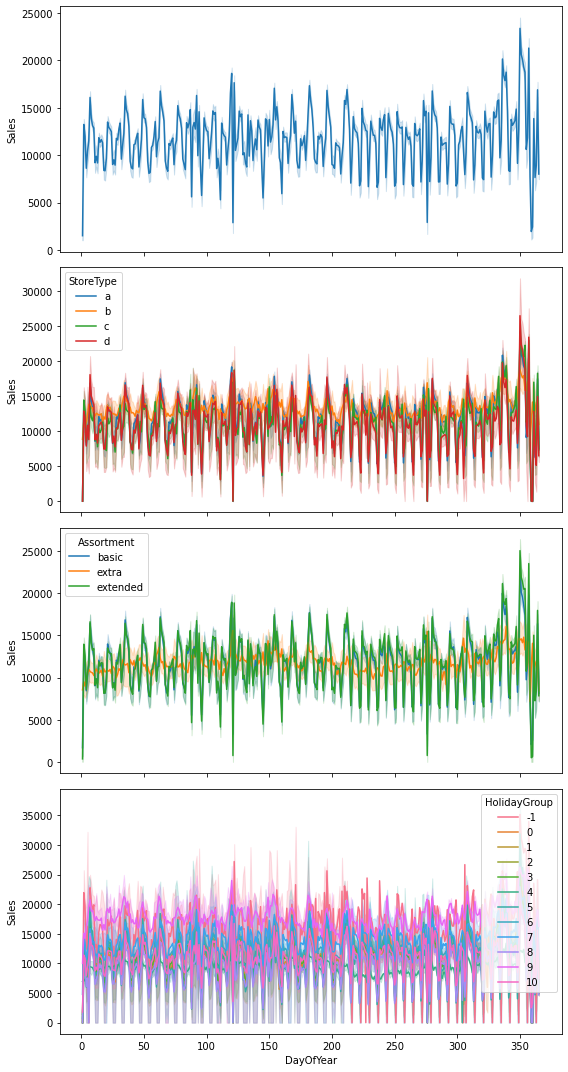

In [23]:
cats = [None, "StoreType", "Assortment", "HolidayGroup"]

fig, axes = plt.subplots(
    nrows=len(cats), figsize=(8, 15), sharex="col", sharey="row")
for cat, ax in zip(cats, axes.flat):
    sns.lineplot(x="DayOfYear", y="Sales", data=subset_train_extracted_features, hue=cat, ax=ax)
    

plt.tight_layout()

## Features Distributions
### Non-Categorical

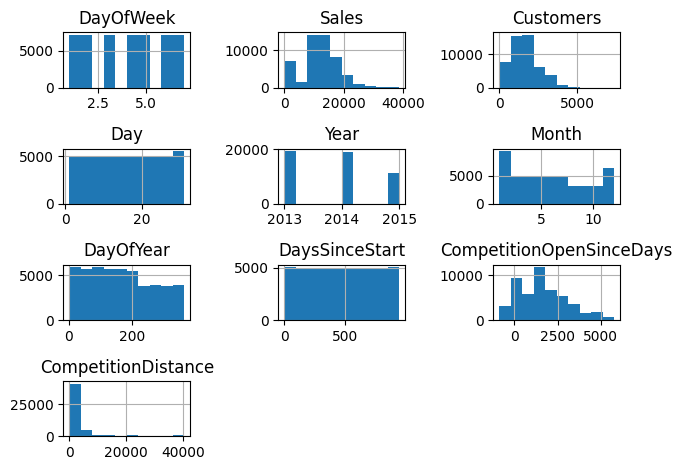

In [32]:


non_cat_sel = make_column_selector(dtype_exclude=[bool, "category"])
non_cat = non_cat_sel(subset_train_extracted_features)
subset_train_extracted_features[non_cat].hist()
plt.tight_layout()

### Takeawys
1. CompetetionDistance, CompetitionOpenSinceDays: PowerTransform -> Normal / Unskew
2. Sales: TargetTransform  PowerTransform
3. Normalize Continous Fatures (Day, Year, Month, DayOfYear, DayOfWeek, DaysSinceStart): MinMaxScaler
4. Categorical:  dummy / onehot



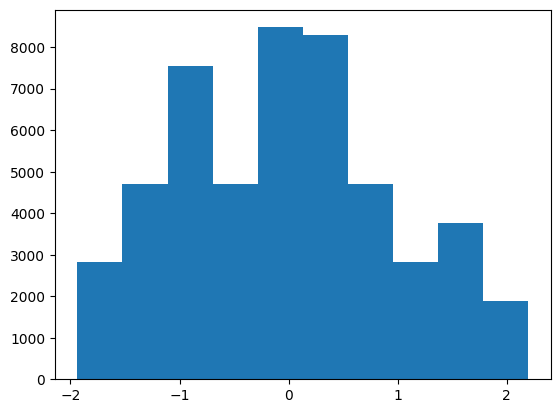

In [47]:
from sklearn.preprocessing import PowerTransformer, RobustScaler
_ = plt.hist(PowerTransformer().fit_transform(subset_train_extracted_features[["CompetitionDistance"]]))

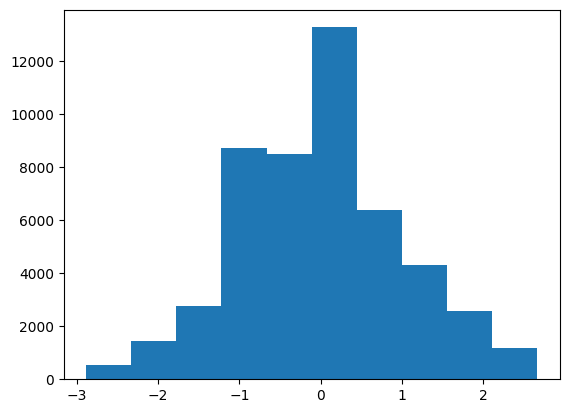

In [50]:
from sklearn.preprocessing import PowerTransformer, RobustScaler
_ = plt.hist(PowerTransformer().fit_transform(subset_train_extracted_features[["CompetitionOpenSinceDays"]]))